In [1]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(1)
# base station location
base_X = 25
base_Y = -100
# transmission energy and receive energy J/bit
ETx = 50*0.000000001
ERc = ETx
# amplification coefficientds J/bit/m^2
epsilon_amp = 10*0.000000000001
# number of clusters
num_clusters = 5
# number of nodes
num_nodes = 100
# initial energy of one node
energy = 0.1
# size of a packet
packet_bit = 2000
# aggregation energy
aggr = 5*0.000000001
# gather x bits together and aggregate them into 0.3 * x bits
aggr_rate = 0.25
# P and 1/P calculating threshould
P = num_clusters / (num_nodes * 1.0)
one_by_P = num_nodes // num_clusters

In [3]:
# cluster class
class Cluster:
    def __init__(self):
        # nodes in one cluster
        self.nodes = []
        # cluster head, type (node)
        self.head = None
        # number of bits awaiting aggregation
        self.bits = 0
    
    # add one node into the cluster
    def add(self, node):
        self.nodes.append(node)
      
    # tell whether the node is the cluster head
    def is_head(self, node):
        return node == self.head
    
    # quick calculation of the square of distance between one node and the cluster head
    def dis(self, node):
        return distance(node.X, self.head.X, node.Y, self.head.Y)

In [4]:
# square of distance instead of distance
def distance(x_1, x_2, y_1, y_2):
    return (x_1 - x_2)**2 + (y_1 - y_2)**2

In [5]:
def T(r):
    #print(P, one_by_P, r, P / (1 - P * (r % one_by_P)))
    return P / (1 - P * (r % one_by_P))

In [6]:
import random

class Node:
    def __init__(self, x, y):
        # (X,Y)
        self.X = x
        self.Y = y
        # remaining energy
        self.energy = energy
        # false means the nodes alive, otherwise dead
        self.die = False
        self.last = -1
        self.cluster = None
    
    def elect(self, r, clusters):
        self.cluster = None
        if r % one_by_P == 0:
            self.last = -1
        if (self.last == -1 or self.last + one_by_P <= r % one_by_P) and not self.die:
            if random.uniform (0,1) <= T(r):
                cluster = Cluster()
                cluster.add(self)
                cluster.head = self
                clusters.append(cluster)
                self.last = r
                self.cluster = cluster
                #print(r, len(clusters))
    
    def select(self, r, clusters):
        if self.cluster != None:
            return
        min_dis = 100000000
        cluster = -1
        for i in range(len(clusters)):
            if min_dis > clusters[i].dis(self):
                cluster = i
                min_dis = clusters[i].dis(self)
        #print(len(clusters), cluster)
        if cluster == -1:
            return
        clusters[cluster].add(self)
        self.cluster = clusters[cluster]
    
    def direct(self):
        transmission = ETx * packet_bit
        amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
        if self.energy < transmission + amplification:
            self.die = True
        else:
            self.energy -= (transmission + amplification)
    
    def send(self):
        if self.cluster.is_head(self):
            if self.cluster.bits == 0:
                transmission = ETx * packet_bit
                amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification)
            else:
                transmission = ETx * aggr_rate * (packet_bit + self.cluster.bits)
                amplification = epsilon_amp * aggr_rate * (packet_bit + self.cluster.bits) * distance(self.X, base_X, self.Y, base_Y)
                #print(transmission, amplification, aggr, self.energy)
                if self.energy < transmission + amplification + aggr:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification + aggr)
                self.cluster.bits = 0
        else:
            if self.cluster.head.die:
                self.die = True
                return
            transmission = ETx * packet_bit
            amplification = epsilon_amp * packet_bit * self.cluster.dis(self)
            if self.energy < transmission + amplification:
                self.die = True
            else:
                self.energy -= (transmission + amplification)
            receive = ERc * packet_bit
            self.cluster.head.energy -= receive
            self.cluster.bits += packet_bit

In [7]:
num_nodes = 200
Xs = uniform.rvs(loc=0, scale=50, size=num_nodes)
Ys = uniform.rvs(loc=0, scale=50, size=num_nodes)

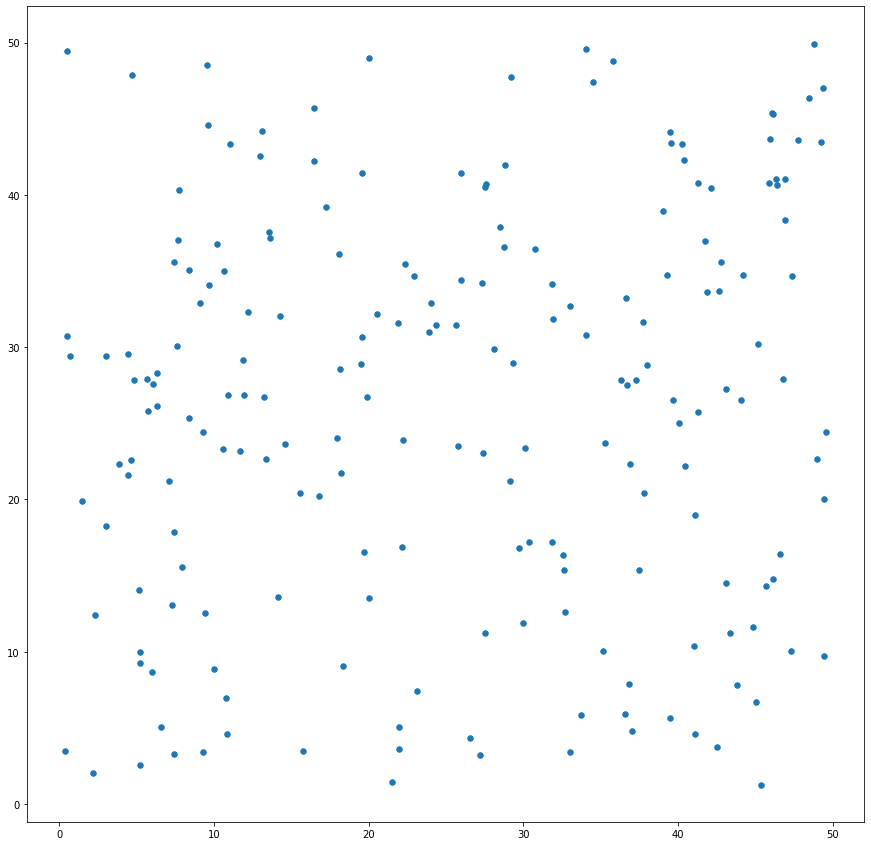

In [8]:
plt.figure(figsize=(15, 15))
plt.scatter(Xs, Ys, s = 30)

0 number of nodes dead 0
400 number of nodes dead 165
800 number of nodes dead 200


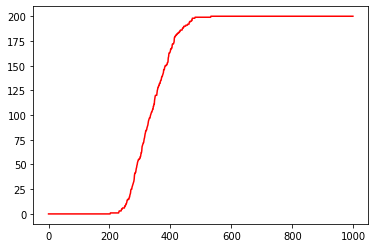

In [24]:
packet_bit = 2000
energy = 0.1
num_rounds = 1000
random.seed(1)
color = ['red', 'blue', 'green', 'yellow', 'purple']
index = -1
for k in [1]:
    index += 1
    Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
    clusters = []
    dead = []
    num = []
    P = 0.05
    one_by_P = 1/P
    for i in range(num_rounds):
        if i%400 == 0:
            print(i, "number of nodes dead", len(dead))
        num.append(len(dead))
        #print("energy", Nodes[0].energy)
        clusters = []
        for node in Nodes:
            node.elect(i, clusters)
        if len(clusters) == 0:
            for j in range(num_nodes):
                if j not in dead:
                    Nodes[j].direct()
                    if Nodes[j].die:
                        dead.append(j)
        else:
            for node in Nodes:
                node.select(i, clusters)
            for j in range(num_nodes):
                if j not in dead and not Nodes[j].cluster.is_head(Nodes[j]):
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)
            for j in range(num_nodes):
                if j not in dead and Nodes[j].cluster.is_head(Nodes[j]):
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)

    plt.plot(range(num_rounds), num, color = color[index])

In [10]:
from sklearn.cluster import KMeans
data = np.transpose(np.asarray([Xs, Ys]))
kmeans = KMeans(n_clusters=5, random_state=0).fit(data)
labels = kmeans.labels_

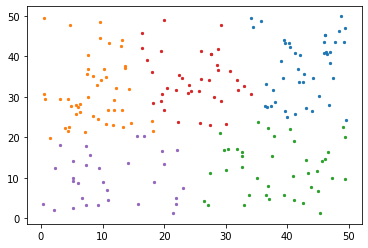

In [18]:
plt.scatter(Xs[[i for i in range(200) if labels[i] == 0]], Ys[[i for i in range(200) if labels[i] == 0]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 1]], Ys[[i for i in range(200) if labels[i] == 1]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 2]], Ys[[i for i in range(200) if labels[i] == 2]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 3]], Ys[[i for i in range(200) if labels[i] == 3]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 4]], Ys[[i for i in range(200) if labels[i] == 4]], s = 5)

In [14]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, random_state=0).fit(data)
gm.means_

array([[38.27514834, 14.20043286],
       [18.74184277, 36.07234063],
       [40.40496287, 37.60444973],
       [11.65395838,  8.05850199],
       [ 8.97408133, 25.4444527 ]])

In [19]:
labels = gm.predict(data)

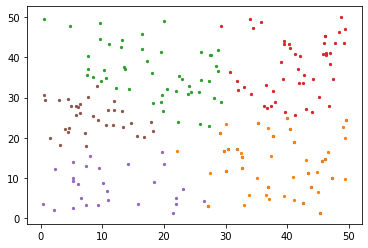

In [20]:
plt.scatter(Xs[[i for i in range(100) if labels[i] == 0]], Ys[[i for i in range(100) if labels[i] == 0]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 0]], Ys[[i for i in range(200) if labels[i] == 0]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 1]], Ys[[i for i in range(200) if labels[i] == 1]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 2]], Ys[[i for i in range(200) if labels[i] == 2]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 3]], Ys[[i for i in range(200) if labels[i] == 3]], s = 5)
plt.scatter(Xs[[i for i in range(200) if labels[i] == 4]], Ys[[i for i in range(200) if labels[i] == 4]], s = 5)

In [30]:
Nodes = np.asarray([Node(Xs[i], Ys[i]) for i in range(num_nodes)])
dead = []
nums = []
j = -1
C = []
for i in range(num_rounds):
    if len(dead) >= num_nodes - 1:
        nums.append(len(dead))
        continue
    nums.append(len(dead))
    if i % 50 == 0:
        print(i, "number of nodes dead", len(dead))
    index = np.asarray([i for i in range(num_nodes) if i not in dead])
    survive = data[[i for i in range(num_nodes) if i not in dead]]
    num_clusters = max(int((num_nodes - len(dead))*0.05 + 1), 3)
    kmeans = KMeans(n_clusters = num_clusters, random_state=0, max_iter = 5).fit(data)
    C = [Cluster() for i in range(num_clusters)]
    labels = kmeans.labels_
    for k in range(num_clusters):
        C[k].nodes = Nodes[index[[j for j in range(len(survive)) if labels[j] == k]]]
        for q in index[[j for j in range(len(survive)) if labels[j] == k]]:
            Nodes[q].cluster = C[k]
    for c in C:
        maxE = 0
        maxN = None
        for n in c.nodes:
            if n.energy > maxE:
                maxN = n
                maxE = n.energy
        if maxN is not None:
            c.head = maxN
    for k in range(num_nodes):
        if k not in dead and not Nodes[j].cluster.is_head(Nodes[j]):
            if Nodes[k].cluster.head.die:
                Nodes[k].direct()
            else:
                Nodes[k].send()
            if Nodes[k].die:
                dead.append(k)
    for k in range(num_nodes):
        if k not in dead and Nodes[j].cluster.is_head(Nodes[j]):
            if Nodes[k].cluster.head.die:
                Nodes[k].direct()
            else:
                Nodes[k].send()
            if Nodes[k].die:
                dead.append(k)

0 number of nodes dead 0
50 number of nodes dead 0
100 number of nodes dead 0
150 number of nodes dead 0
200 number of nodes dead 0
250 number of nodes dead 0
300 number of nodes dead 0
350 number of nodes dead 0
400 number of nodes dead 10


In [33]:
Nodes = np.asarray([Node(Xs[i], Ys[i]) for i in range(num_nodes)])
dead = []
nums1 = []
j = -1
C = []
for i in range(num_rounds):
    if len(dead) == 200:
        nums1.append(len(dead))
        continue
    nums1.append(len(dead))
    if i % 50 == 0:
        print(i, "number of nodes dead", len(dead))
    index = np.asarray([i for i in range(num_nodes) if i not in dead])
    survive = data[[i for i in range(num_nodes) if i not in dead]]
    num_clusters = max(int((num_nodes - len(dead))*0.05 + 1), 3)
    kmeans = GaussianMixture(n_components=5, random_state=0, max_iter = 5).fit(data)
    C = [Cluster() for i in range(num_clusters)]
    labels = kmeans.predict(data)
    for k in range(num_clusters):
        C[k].nodes = Nodes[index[[j for j in range(len(survive)) if labels[j] == k]]]
        for q in index[[j for j in range(len(survive)) if labels[j] == k]]:
            Nodes[q].cluster = C[k]
    for c in C:
        maxE = 0
        maxN = None
        for n in c.nodes:
            if n.energy > maxE:
                maxN = n
                maxE = n.energy
        if maxN is not None:
            c.head = maxN
    for k in range(num_nodes):
        if k not in dead and not Nodes[j].cluster.is_head(Nodes[j]):
            if Nodes[k].cluster.head.die:
                Nodes[k].direct()
            else:
                Nodes[k].send()
            if Nodes[k].die:
                dead.append(k)
    for k in range(num_nodes):
        if k not in dead and Nodes[j].cluster.is_head(Nodes[j]):
            if Nodes[k].cluster.head.die:
                Nodes[k].direct()
            else:
                Nodes[k].send()
            if Nodes[k].die:
                dead.append(k)

0 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

50 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

100 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

150 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

200 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

250 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

300 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

350 number of nodes dead 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

400 number of nodes dead 56


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\m

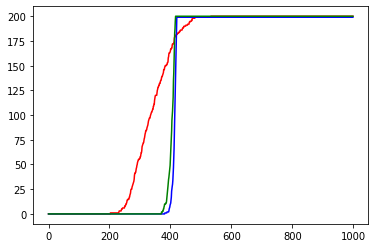

In [34]:
plt.plot(range(num_rounds), num, color = "red")
plt.plot(range(num_rounds), nums, color = "blue")
plt.plot(range(num_rounds), nums1, color = "green")

In [ ]:
Nodes = [None for i in range(num_nodes)]

for i in range(num_nodes):
    Nodes[i] = Node(Xs[i], Ys[i])
num2 = []
dead = []
for i in range(num_rounds):
    num2.append(len(dead))
    if i%400 == 0:
        print(i, "number of nodes dead", len(dead))
    #print(Nodes[0].energy)
    for j in range(num_nodes):
        if j not in dead:
            Nodes[j].direct()
            if Nodes[j].die:
                dead.append(j)

In [ ]:
plt.plot(range(len(num_rounds)), num, color = "red")
plt.plot(range(len(num_rounds)), num2, color = "green")
plt.plot(range(len(num_rounds)), nums, color = "blue")